The [Smoluchowski equation](https://en.wikipedia.org/wiki/Smoluchowski_coagulation_equation) has analytical solutions for a few simple coagulation kernels (without the fragmentation part; see Appendix A4 in [Kenyon & Luu (1998)](https://ui.adsabs.harvard.edu/abs/1998AJ....115.2136K/abstract) for a summary and references therein).

In this notebook, we compares our results with the analytic solutions for two cases with a constant kernel and with a sum kernel.

---
PS: The results of solving the Smoluchowski equation numerically are known to depend on resolution, initial setup, and the length of time step (and also the `Python` environment and the machine). It is thus normal if you get slightly different results. If you get qualitatively different results, be sure to test different setups.

# Import Modules

In [8]:
from astropy import units as u
from astropy import constants as c
import numpy as np
import scipy as sp
import mpmath as mp
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
%matplotlib nbagg
np.set_printoptions(edgeitems=5, linewidth=180, precision=6)
mp.mp.dps = 25

In [10]:
from rubble import Rubble, RubbleData

In [11]:
dt_1d = 86400; dt_1yr = dt_1d * 365.25

# Constant Kernel

If $n_0$ is the initial number of particles with mass $m_i$, the number of bodies with mass $m_k = km_i$ at a time $t$ is
    
$$ n_k = n_0 f^2 (1 - f)^{k-1}, $$

where $f = 1/(1+0.5 \eta_1)$ and $\eta_1 = \alpha_c n_0 t$ is the dimensionless time.

In [53]:
# First, do a small-scale quick test

r = Rubble(101, 1e-4, 2e-3, 0, 0.2, 
           delta_dist=1e-4, coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name = "constK")
r.simple_St_flag = True
r.vel_dist_flag = False
r.bouncing_flag = False
r.frag_flag = False
# the following line sets kernel to a small constant b/c with Sigma_d = 0.2, 
# the number of particles at 1e-4, i.e., N(a=1e-4), is huge
r._user_setup(test='constK')

In [54]:
n0 = r.Nk[1]
Aij = r.K[1][1] / r.vi_fac[1][1]
tprime = 1 / (Aij * n0)
print(n0, Aij, Aij * n0, tprime)

764562229648.4318 3.1415926535897934e-14 0.024019430838757457 41.632959861247514


In [55]:
# for a fast test run
r.run(tprime*250/dt_1yr, (tprime/4)/dt_1yr, (tprime)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


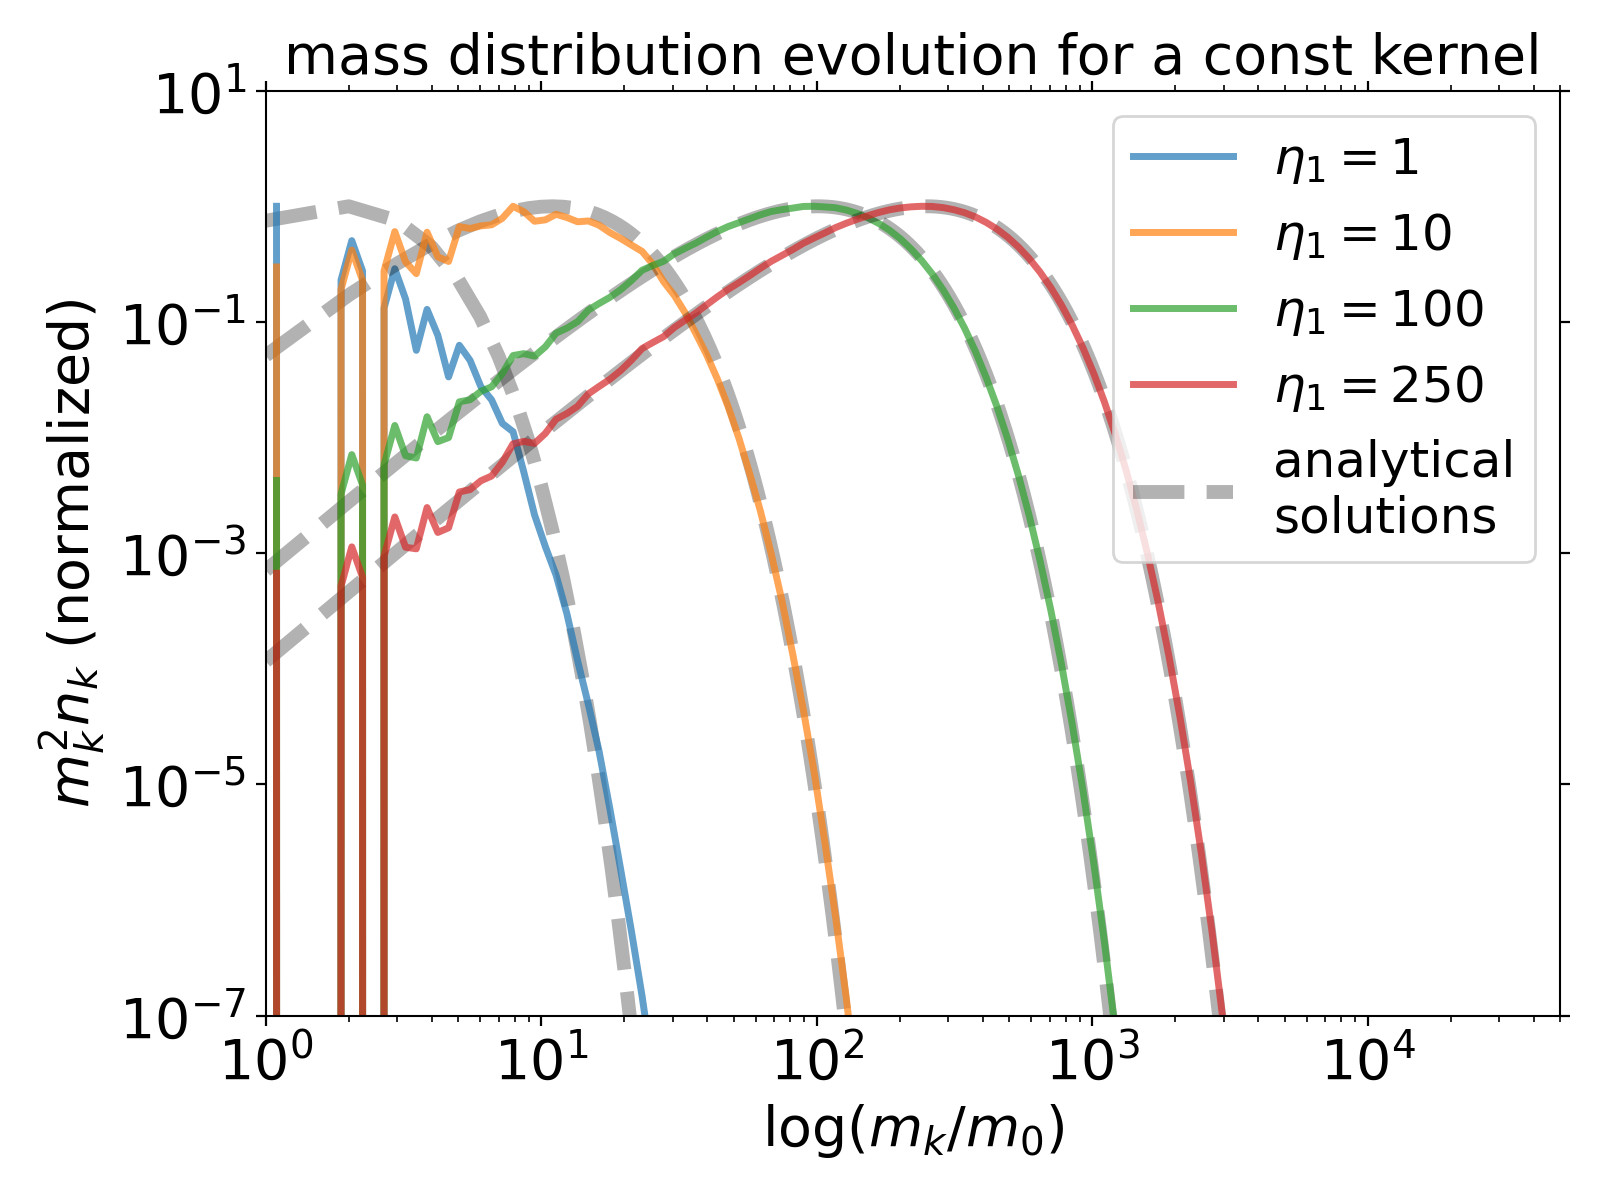

In [56]:
rd = RubbleData("constK.dat")
fig, ax = plt.subplots(figsize=(8, 6)); k = np.arange(1, 1e4);
tmp_Nk = rd.Nk[0]; tmp_n0 = tmp_Nk[1] / (rd.m[3] - rd.m[1]) / 15
for ntp in [1, 10, 100, 250]:
    f = 1 / (1 + 0.5 * ntp); f_nk = 1 * f**2 * (1 - f)**(k - 1) *k**2
    ax.loglog(k, f_nk/f_nk.max(), '--k', lw=5, alpha=0.3)
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * tprime))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.loglog(rd.m[2:-1]/rd.m[1], tmp_N / tmp_N.max(), lw=2.5, alpha=0.7, label=f'$\eta_1 = {ntp}$')

ax.loglog([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(ylim=(1e-7, 10), xlim=(1, 5e4), xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a const kernel')
fig.tight_layout()

### Now, for a larger-scale longer test

In [5]:
r = Rubble(254, 1e-4, 1e-2, 0, 0.18, 
           delta_dist=1e-4, coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name = "constK_longer")
r.simple_St_flag = True
r.vel_dist_flag = False
r.bouncing_flag = False
r.frag_flag = False
# the following line sets kernel to a small constant b/c with Sigma_d = 0.2, 
# the number of particles at 1e-4, i.e., N(a=1e-4), is huge
r._user_setup(test='constK')

In [6]:
n0 = r.Nk[1]
Aij = r.K[1][1] / r.vi_fac[1][1]
tprime = 1 / (Aij * n0)
print(n0, Aij, Aij * n0, tprime)

1132486891938.2676 3.141592653589792e-14 0.03557812499999998 28.107158541941164


In [ ]:
# N.B.: this run will cost hours, better put in on HPC
r.run(tprime*10000/dt_1yr, (tprime/4)/dt_1yr, (tprime)/dt_1yr, no_burnin=True)

In [5]:
rd = RubbleData("constK_longer.dat")
rd.shrink_data("constK2.dat", 10, keep_first_n=10) # shrink data to reduce the size of this git repo

<IPython.core.display.Javascript object>


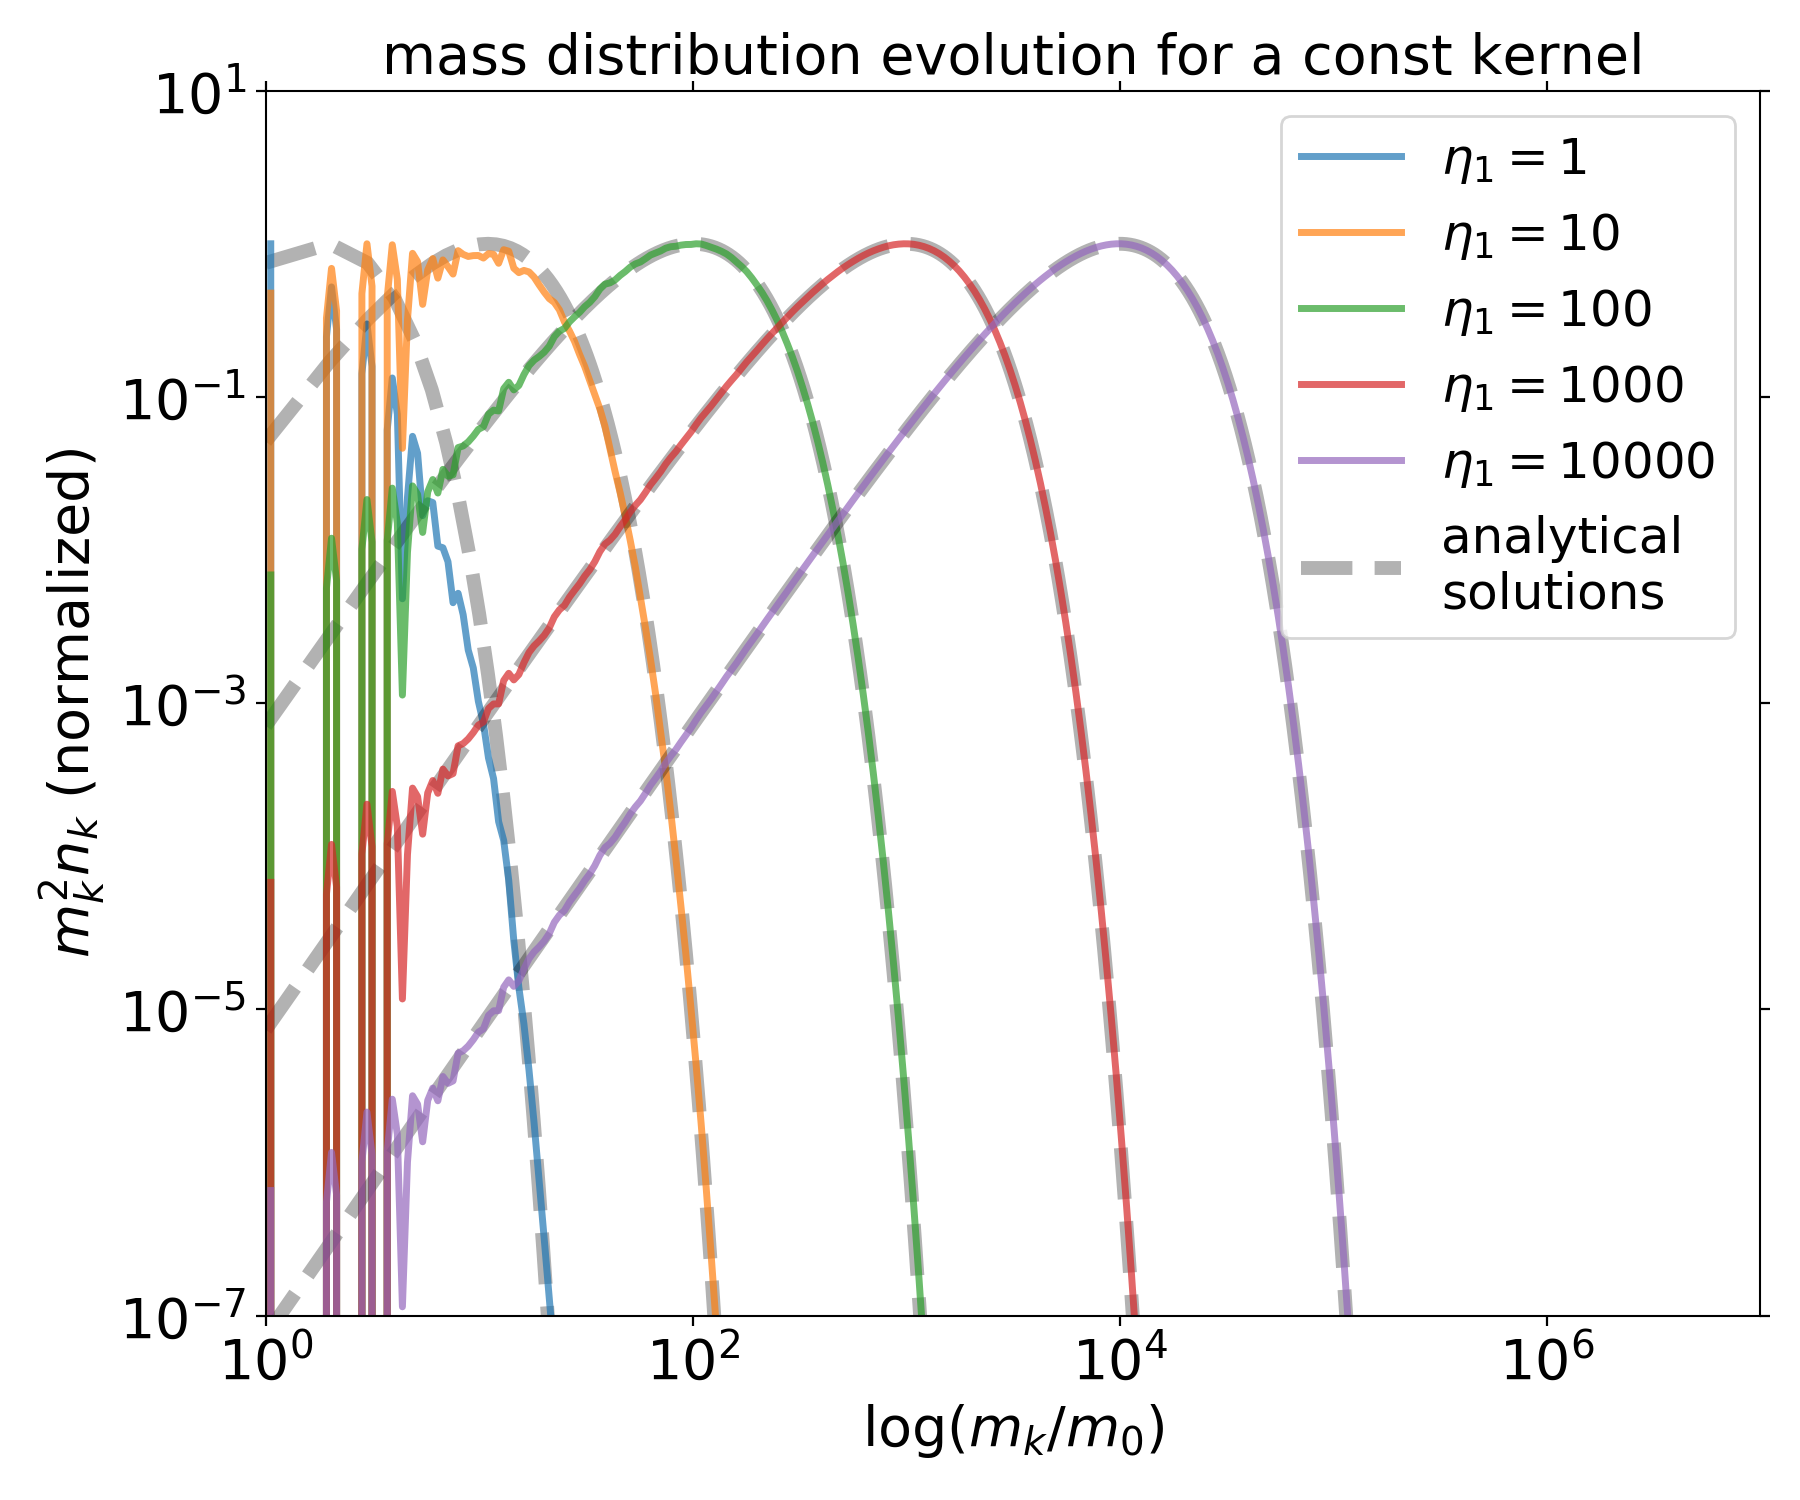

In [7]:
rd = RubbleData("constK2.dat")
rxplt.plt_params('l'); fig, ax = plt.subplots(figsize=(9, 7.5)); k = np.arange(1, 2e5); tprime = 28.107158541941153
tmp_Nk = rd.Nk[0]; tmp_n0 = tmp_Nk[1] / (rd.m[3] - rd.m[1]) / 15
for ntp in [1, 10, 100, 1000, 10000]:
    f = 1 / (1 + 0.5 * ntp); f_nk = 1 * f**2 * (1 - f)**(k - 1) *k**2
    ax.loglog(k, f_nk/f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * tprime))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.loglog(rd.m[2:-1]/rd.m[1], tmp_N / tmp_N.max(), lw=2.5, alpha=0.7, label=f'$\eta_1 = {ntp}$')

ax.loglog([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(ylim=(1e-7, 10), xlim=(1, 1e7), xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a const kernel')
fig.tight_layout()

# Sum Kernel

The solution for $A_{ij} = \beta_c (m_i + m_j)$ is

$$ n_k = n_0 \frac{k^{k-1}}{k!} f(1-f)^{k-1} \exp [-k(1-f)], $$

where $f = \exp(-\eta_2)$ and $\eta_2 = \beta_c n_0 t$ is the dimensionless time.

In [57]:
# exp[-k(1-f)] in the analytical solution is much larger than what numpy can handle, we need mpmath
mp.mp.dps = 200
lgk = np.linspace(0, 28, 256)
mpmpf = np.frompyfunc(mp.mpf, 1, 1)
lgk = mpmpf(lgk)
k = 10**lgk
mpfac = np.frompyfunc(mp.factorial, 1, 1)
mplog10 = np.frompyfunc(mp.log10, 1, 1)
mpexp = np.frompyfunc(mp.exp, 1, 1)
lgkfac = mplog10(mpfac(k))

In [58]:
# First, do a small-scale quick test

# make the mass of the first bin = 1.0
a_min = (1.0/ (4*np.pi/3 * 1.6))**(1/3); print(a_min);
r = Rubble(254, a_min, 2e6, 0, 1.0, 
           delta_dist=a_min, coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name="sumK", beta_c=1.0) # beta_c is the kernel coefficient: K_ij = beta_c (m_i + m_j)

# manually set the number of m_0 to 1.0 (using Nk[1] b/c Nk[0] is for ghost zone)
r.Nk[1] = 1.0
r.sigma[1] = r.Nk[1] * 3*r.m[1]
r.Na[1] = r.Nk[1] * 3
r._Sigma_d = r.get_Sigma_d(r.Nk)
r.Sigma_d = r.get_Sigma_d(r.Nk)

r.simple_St_flag = True
r.vel_dist_flag = False
r.bouncing_flag = False
r.frag_flag = False
# the following line sets the kernel to sum kernel
r._user_setup(test='sumK')

0.5303922089735277


In [59]:
n0 = r.Nk[1]; beta_c = 1.0 ; tprime = 1 / (beta_c * n0)
n0, beta_c * n0, tprime, tprime/dt_1yr

(1.0, 1.0, 1.0, 3.168808781402895e-08)

In [60]:
r.run(tprime*10/dt_1yr, (tprime/4)/dt_1yr, (tprime)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


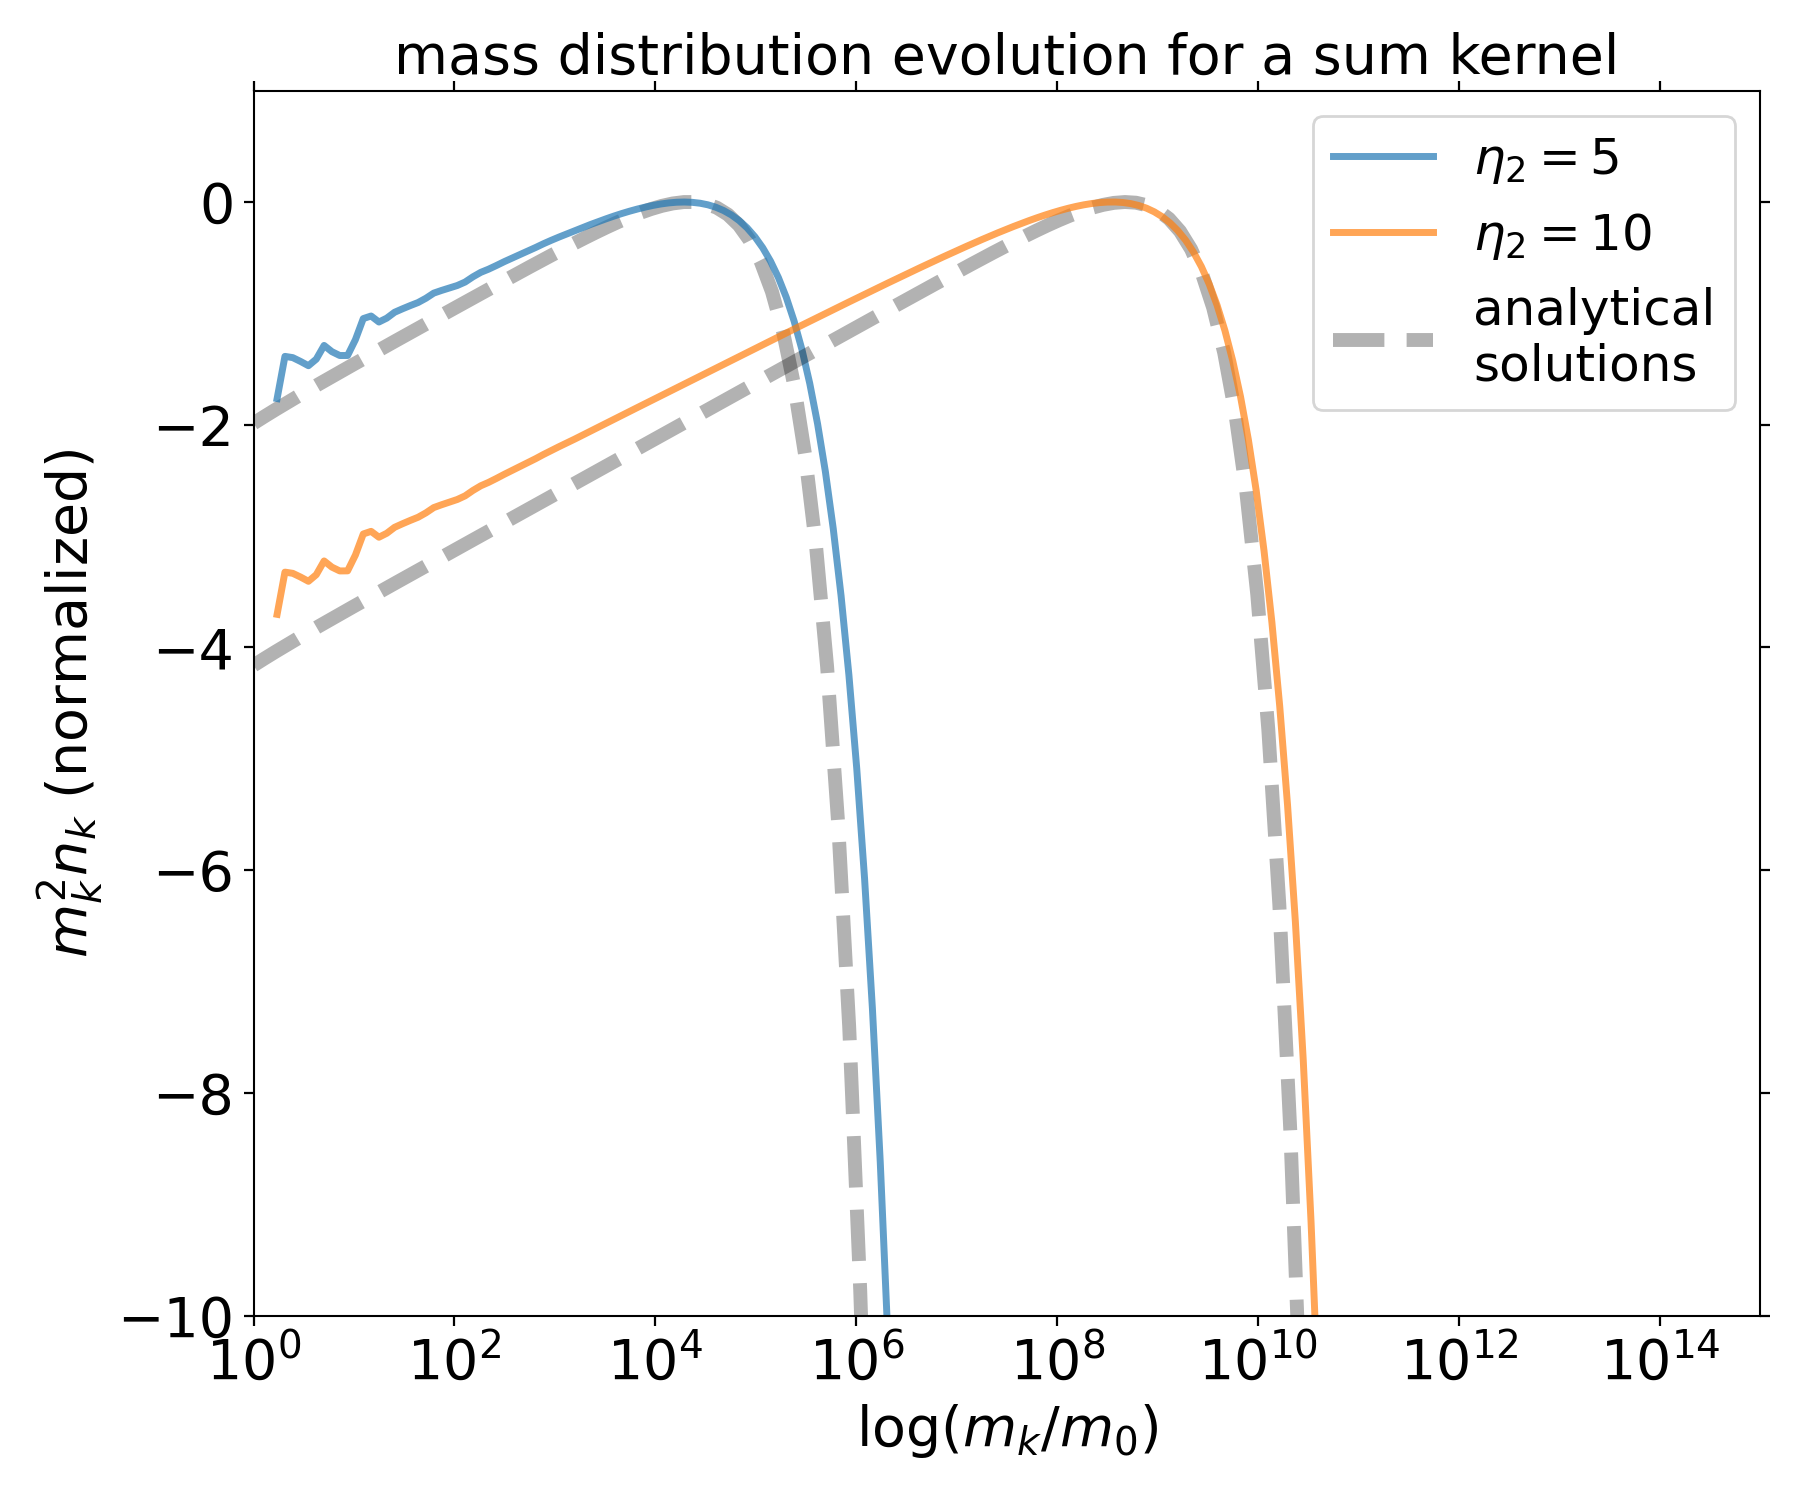

/home/u5/rixin/opt/py3puma/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/u5/rixin/opt/py3puma/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


In [61]:
rd = RubbleData("sumK.dat"); tprime = 1.0
fig, ax = plt.subplots(figsize=(9, 7.5)); maxis = rd.m[2:-1]/rd.m[1]
for ntp in [5, 10]:
    f = mp.exp(-ntp); 
    #lgf = (k-1)*lgk - lgkfac + mp.log10(f) + (k-1)*mp.log10(1-f) + (-k*(1-f))*mp.log10(np.e)
    f_nk = (k-1)*lgk - lgkfac + mplog10(f * (1-f)**(k-1) * mpexp(-k*(1-f)) * k**2)
    ax.semilogx(k, f_nk - f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * tprime))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.semilogx(maxis, np.log10(tmp_N / tmp_N.max()), lw=2.5, alpha=0.7, label=f'$\eta_2 = {ntp}$')
ax.semilogx([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(ylim=(-10, 1), xlim=(1, 1e15), xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a sum kernel')     
fig.tight_layout()

### Now, for a larger-scale longer test

Because particles grow exponentially, [Brauer+2008](https://ui.adsabs.harvard.edu/abs/2008A%26A...480..859B/abstract) had already pointed out that "the initial particle size will always play a role" in this situation. Thus, we tweak the first mass bin a bit to fine tune the results

In [44]:
# tweak the mass of the smallest size a bit to get the best results
a_min = (1.085/ (4*np.pi/3 * 1.6))**(1/3); print(a_min);
r = Rubble(374, a_min, 2e9, 0, 1.0, 
           delta_dist=a_min, coag2nearest=True, # put coagulation mass into the bin nearest to the mass sum
           run_name="sumK_longer", beta_c=1.0) # beta_c is the kernel coefficient: K_ij = beta_c (m_i + m_j)

# manually set the number of m_0 to 1.0 (using Nk[1] b/c Nk[0] is for ghost zone)
r.Nk[1] = 1.0
r.sigma[1] = r.Nk[1] * 3*r.m[1]
r.Na[1] = r.Nk[1] * 3
r._Sigma_d = r.get_Sigma_d(r.Nk)
r.Sigma_d = r.get_Sigma_d(r.Nk)

r.simple_St_flag = True
r.vel_dist_flag = False
r.bouncing_flag = False
r.frag_flag = False
# the following line sets the kernel to sum kernel
r._user_setup(test='sumK')
r.rerr_th = 1e-6
r.rerr_th4dt = 1e-6

0.5450132350137634


In [45]:
n0 = r.Nk[1]; beta_c = 1.0 ; tprime = 1 / (beta_c * n0)
n0, beta_c * n0, tprime, tprime/dt_1yr

(1.0, 1.0, 1.0, 3.168808781402895e-08)

In [ ]:
# N.B.: this run will cost hours, better put in on HPC
r.run(tprime*30/dt_1yr, (tprime/6)/dt_1yr, (tprime)/dt_1yr, no_burnin=True)

<IPython.core.display.Javascript object>


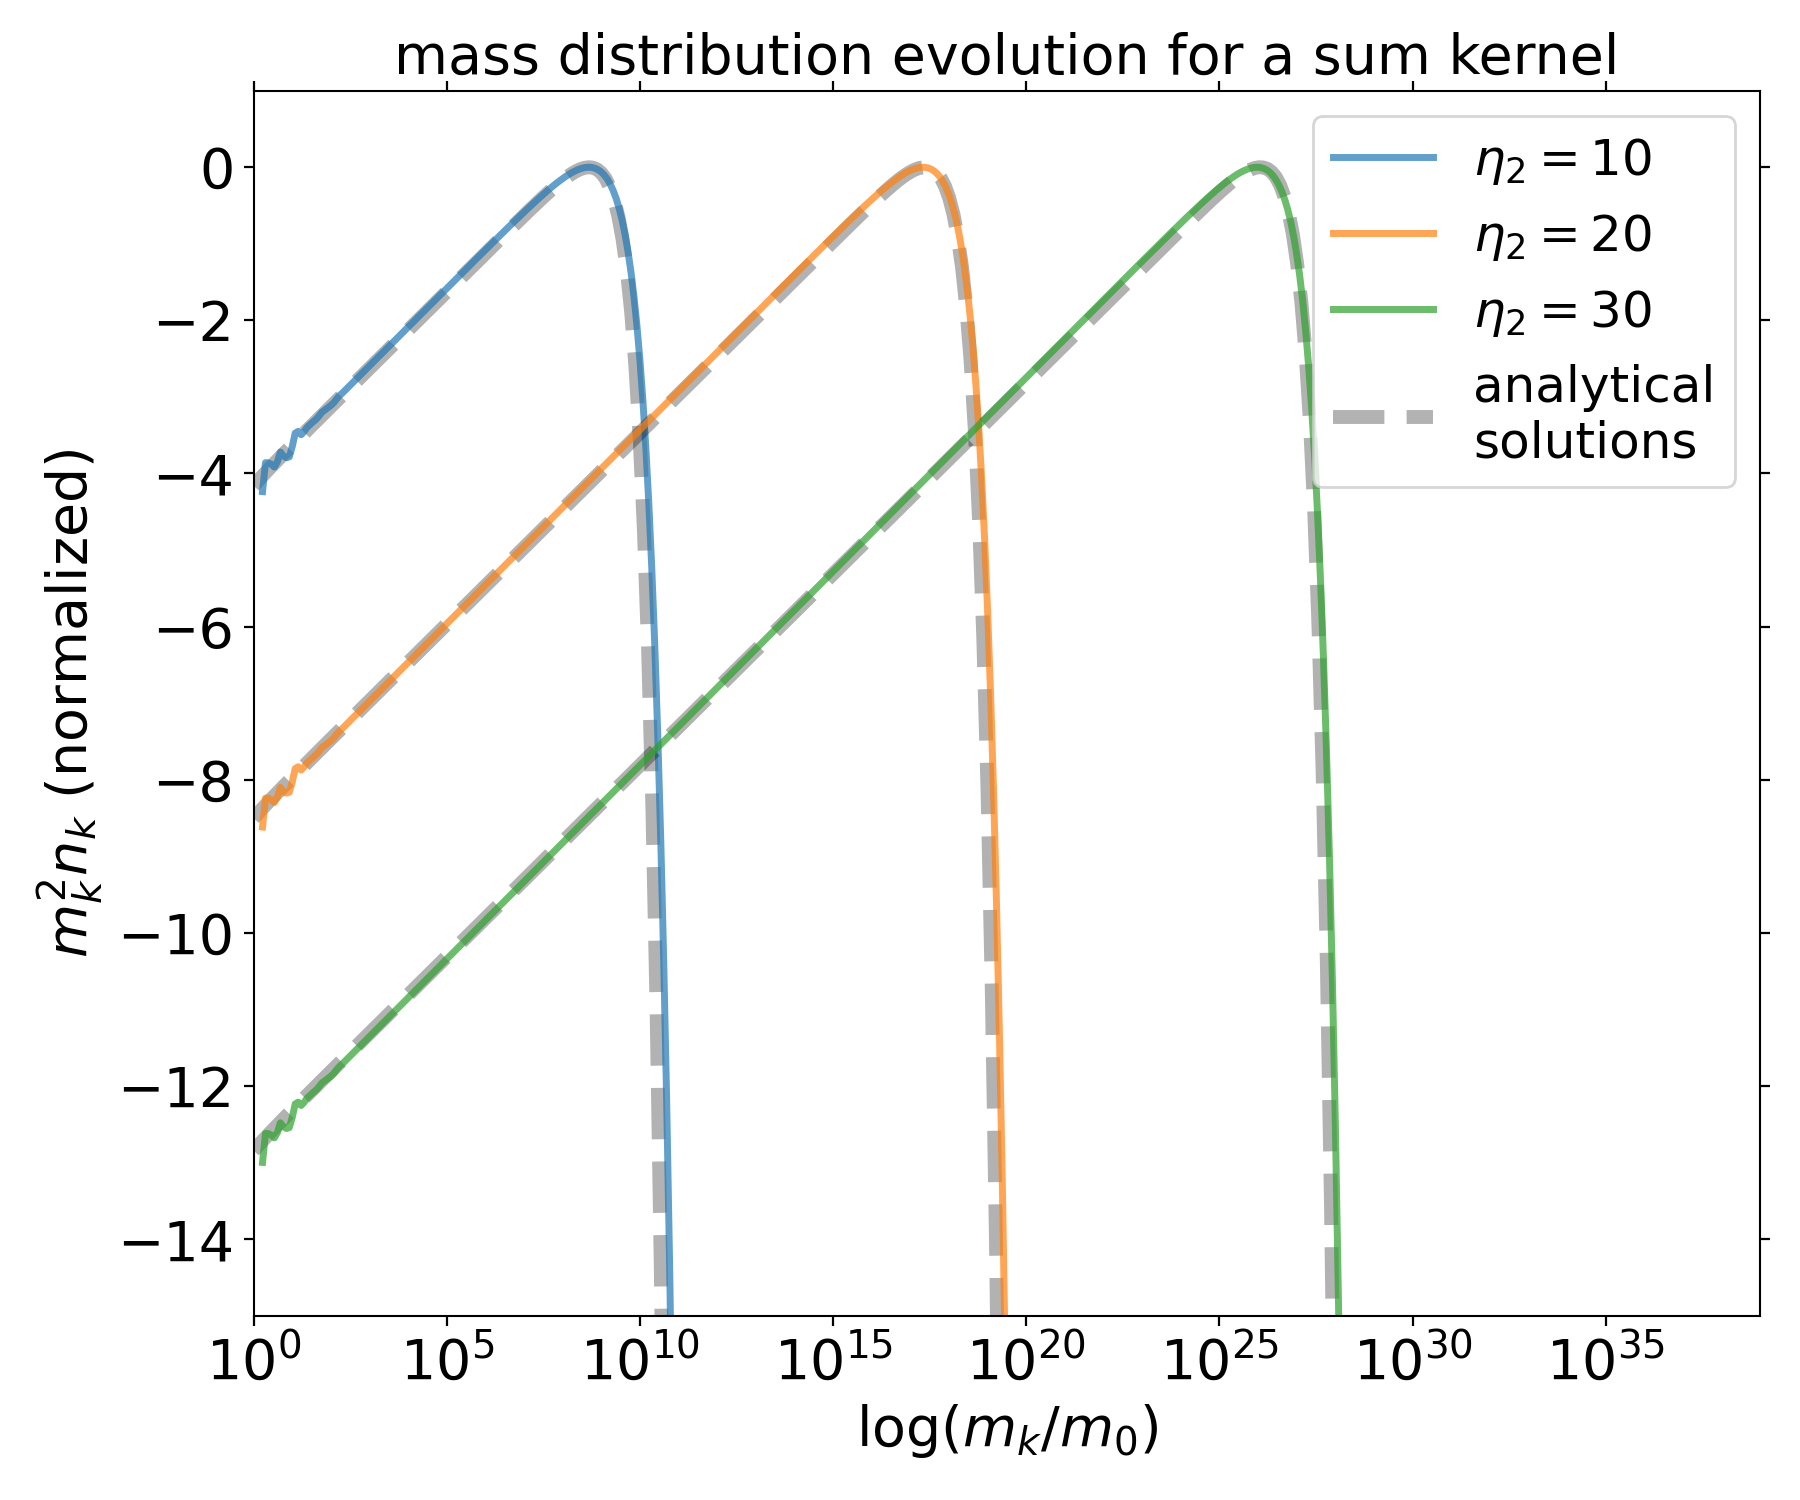

/home/u5/rixin/opt/py3puma/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/u5/rixin/opt/py3puma/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/home/u5/rixin/opt/py3puma/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


In [46]:
rd = RubbleData("sumK_longer.dat")
fig, ax = plt.subplots(figsize=(9, 7.5)); maxis = rd.m[2:-1]/rd.m[1]
for ntp in [10, 20, 30]:
    f = mp.exp(-ntp); 
    #lgf = (k-1)*lgk - lgkfac + mp.log10(f) + (k-1)*mp.log10(1-f) + (-k*(1-f))*mp.log10(np.e)
    f_nk = (k-1)*lgk - lgkfac + mplog10(f * (1-f)**(k-1) * mpexp(-k*(1-f)) * k**2)
    ax.semilogx(k, f_nk - f_nk.max(), '--k', lw=5, alpha=0.3)
    
    t_idx = np.argmin(abs(rd.t*dt_1yr - ntp * tprime))
    tmp_Nk = rd.Nk[t_idx]
    tmp_N = (tmp_Nk[2:-1] + 0.5 * (tmp_Nk[3:] + tmp_Nk[1:-2])) / (rd.m[3:] - rd.m[1:-2]) * (rd.m[2:-1]/rd.m[1])**2
    ax.semilogx(maxis, np.log10(tmp_N / tmp_N.max()), lw=2.5, alpha=0.7, label=f'$\eta_2 = {ntp}$')
ax.semilogx([], [], '--k', lw=5, alpha=0.3, label='analytical\nsolutions'); ax.legend(loc='upper right', handlelength=2)
ax.set(ylim=(-15, 1), xlim=(1, 1e39), xlabel=r'$\log(m_k/m_0)$', ylabel=r"$m_k^2 n_k$ (normalized)",
       title=r'mass distribution evolution for a sum kernel')     
fig.tight_layout()